### This is a notebook to mess around with Problem Set 2 in ML4SP 2024


In [1]:
from scipy.io import loadmat
from xcorr import xcorr
from scipy.linalg import toeplitz
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
s_n = loadmat(f'data/problem2_5_signal.mat')['signal'].flatten()
w_n = loadmat(f'data/problem2_5_noise.mat')['noise'].flatten()

**In this problem, we will consider a FIR Wiener filter setup and use the filter to remove noise. Explain what the desired signal and the error signal of a filter setup is.**

The desired signal is the original signal we aim to recover or estimate, in this case $s_n$, which is noise-free. The error signal is the difference between estimated output from the filter $\hat{s}_n$ w.r.t. the original, ie. $e_n=s_n - \hat{s}_n$. The goal is to minimize this difference, of course.

In [2]:
x_n = s_n + w_n

L = 20 # Filter length
Fs = 8000 # Sampling frequency (stated in problem)
L_range = range(5,50)

mse_vals = []; snr_vals = []

def calculate_snr(signal, noisy_signal):
    signal_power = np.sum(signal ** 2)
    noise_power = np.sum((signal - noisy_signal) ** 2)
    return 10 * np.log10(signal_power / noise_power)

# Compute Wiener filter
r_xx = xcorr(x_n, x_n, L-1)
R_xx = toeplitz(r_xx[L-1:])
r_dx = xcorr(s_n, x_n, L-1)
# the filter
theta = np.linalg.solve(R_xx, r_dx[L-1:])
# Filter noisy signal
s_hat_n = signal.lfilter(theta, 1, x_n)


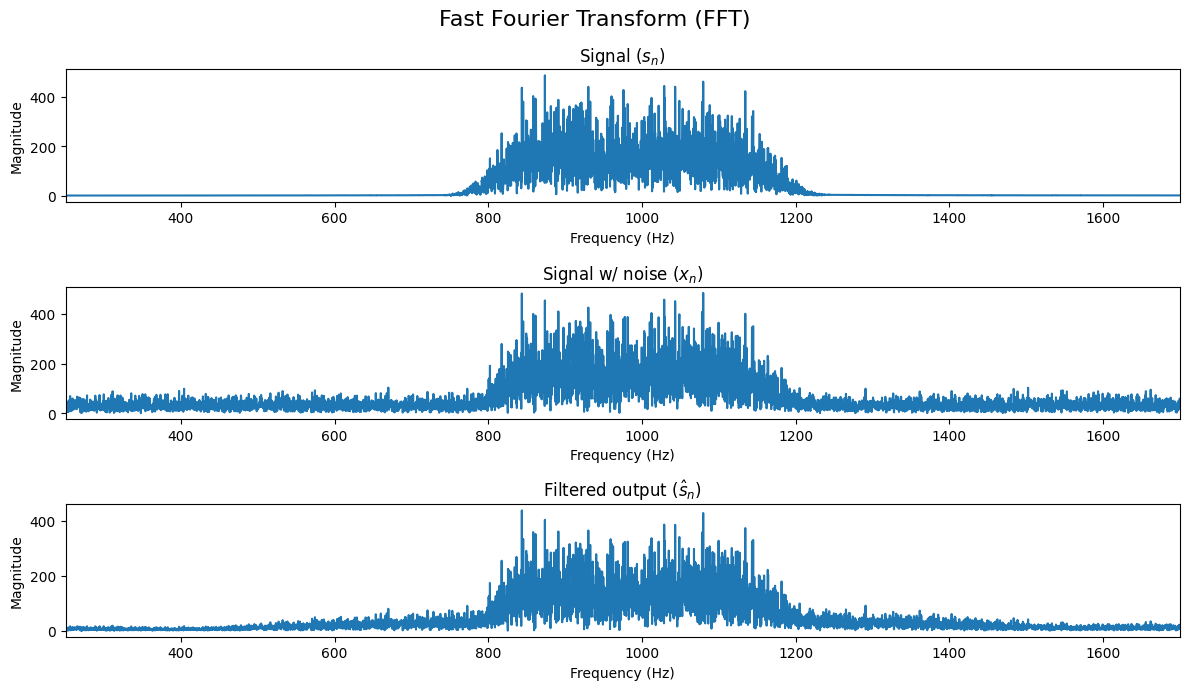

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7))
fig.suptitle('Fast Fourier Transform (FFT)', fontsize=16)
for i, sig in enumerate([(s_n, r"Signal ($s_n$)"), (x_n, r"Signal w/ noise ($x_n$)"), (s_hat_n, r"Filtered output ($\hat{s}_n$)")]):  
    T = len(sig[0])  # signal duration
    t = np.arange(0, len(sig[0])) #T, 1/Fs)  # time vector
    X = np.fft.rfft(sig[0])
    f = np.fft.rfftfreq(len(sig[0]), 1/Fs)
    axes[i].plot(f, abs(X))
    axes[i].set_title(sig[1])
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Magnitude')
    axes[i].set_xlim(250, 1700)
fig.tight_layout()
plt.show()


**FTT Comments**

It is evident that the noise introduced to the signal is reduced after applying the filter, but some residual noise is left, especially in the higher and lower frequency bands outside the 750-1250 Hz range, where the primary signal resides. However, there is still some residual noise in the vicinity of the primary signal band. By tuning the filter length a better suppression of the noise around this range without significantly altering the main signal may be possible. 

Some considerations in choosing my final filter length $L$ have been the following:
- Too large of an $L$ led to some unwanted effects near the primary band of the signal from the frequency response of the filter, a "dip" or attentuation of sorts which may cause distortion. However, it provided the supression or "cutoff" I was looking for regarding frequencies outside of the primary signal band. It is also more computationally expensive, I suppose.
- Too low of an $L$ led to a lot more residual noise inside the primary band range and outside of it, as well. 

After rigorously inspecting the qualitative similarity between the signal and the filtered output, I decided to compute the mean-squared error (MSE) and the signal-to-noise ratio and plot it over a range of $L$'s, as it is very hard to find a definitive difference. However, I also decided to further specify this to the area of interest, namely the range of frequencies inhabited by the original signal, ~750-1250 Hz. My reasoning is that the MSE and SNR metrics when considering the full frequency range could be overemphasizing noise reduction in areas outside this area, leading to the choice of a longer filter lengths.

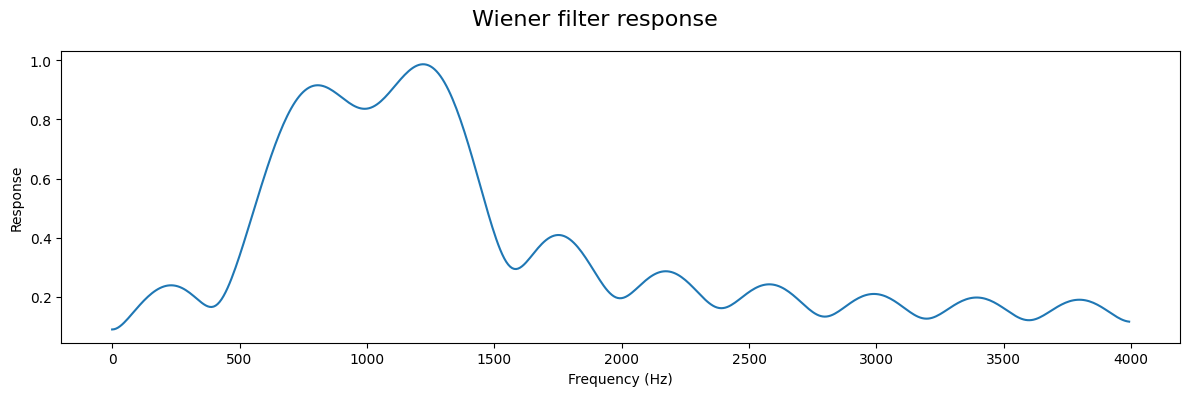

In [4]:
from scipy.signal import freqz
w, h = freqz(theta, fs=Fs)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle('Wiener filter response', fontsize=16)
ax.plot(w, abs(h))
ax.set_ylabel('Response')
ax.set_xlabel('Frequency (Hz)')
fig.tight_layout()
plt.show()

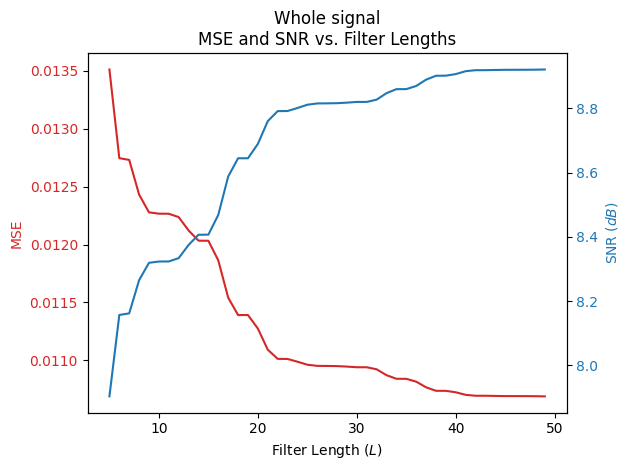

In [5]:
for k in L_range:
    # Compute Wiener filter
    r_xx = xcorr(x_n, x_n, k-1)
    R_xx = toeplitz(r_xx[k-1:])
    r_dx = xcorr(s_n, x_n, k-1)
    theta = np.linalg.solve(R_xx, r_dx[k-1:])
    
    s_hat_n = signal.lfilter(theta, 1, x_n)
    
    mse = np.mean((s_n - s_hat_n) ** 2)
    mse_vals.append(mse)
    
    snr = calculate_snr(s_n, s_hat_n)
    snr_vals.append(snr)

# Plotting...
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Filter Length ($L$)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(L_range, mse_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('SNR ($dB$)', color=color)
ax2.plot(L_range, snr_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Whole signal\nMSE and SNR vs. Filter Lengths')
fig.tight_layout()
plt.show()

From this plot I believe the effect of a larger filter length $L$ diminishes somewhere around 25-30, whereas beforehand it seems to have a noticable gain. This is mirrored in the MSE as well.

A larger $L$ as spoken on before leads to the attenuation in the primary signal's frequency range illustrated by the dip. While this is not ideal, as we try to preserve the original signal, I understand it as the Wiener filter trying to compromise between attenuating the noise at the expense of attenuating some of the signal, as well, which may result in an overall cleaner output signal. Inspecting the band-limited analysis plot below...

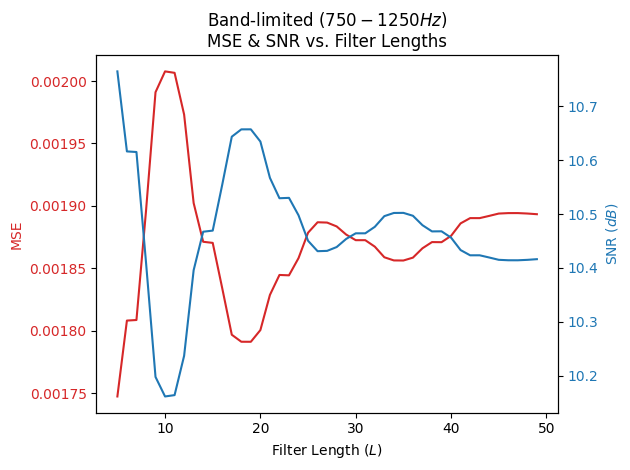

In [6]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq

band_start = 750  # Lower bound of the frequency range of interest
band_stop = 1250  # Upper bound of the frequency range of interest
mse_vals = []; snr_vals = []

# helper
def calculate_weighted_mse_snr(s_n, s_hat_n, Fs, band_start, band_stop):
    # FFT of original and filtered signals
    S = fft(s_n)
    D = fft(s_hat_n)
    
    freqs = fftfreq(len(s_n), 1/Fs) # all frequencies
    
    # Masking for range of interest
    band_mask = (freqs >= band_start) & (freqs <= band_stop)
    S_band = S[band_mask]
    D_band = D[band_mask]
    
    # Reconstructing the signal
    s_n_band = np.real(ifft(S_band, n=len(s_n)))
    s_hat_n_band = np.real(ifft(D_band, n=len(s_hat_n)))
    
    # MSE
    mse_band = np.mean((s_n_band - s_hat_n_band) ** 2)
    
    # SNR
    snr_band = calculate_snr(s_n_band, s_hat_n_band)
    
    return mse_band, snr_band

# weighted loop
for k in L_range:
    # Compute Wiener filter
    r_xx = xcorr(x_n, x_n, k-1)
    R_xx = toeplitz(r_xx[k-1:])
    r_dx = xcorr(s_n, x_n, k-1)
    theta = np.linalg.solve(R_xx, r_dx[k-1:])
    
    # Apply filter to noisy signal
    s_hat_n = signal.lfilter(theta, 1, x_n)
    
    # Calculate weighted MSE and SNR in the primary frequency band
    mse_band, snr_band = calculate_weighted_mse_snr(s_n, s_hat_n, Fs, band_start, band_stop)
    
    mse_vals.append(mse_band)
    snr_vals.append(snr_band)

# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Filter Length ($L$)')
ax1.set_ylabel('MSE', color=color)
ax1.plot(L_range, mse_vals, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('SNR ($dB$)', color=color)
ax2.plot(L_range, snr_vals, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Band-limited ($750-1250Hz$)\nMSE & SNR vs. Filter Lengths')
fig.tight_layout()
plt.show()

This shows that for the area of the signal using $L$ around 18 might be the most beneficial.

To strike a balance between the two, I believe my final answer is I would use a filter length of $L=20$

# 2.6


In [5]:
from scipy import signal
import scipy
import numpy as np
import librosa
import librosa.display # requires np <= 2.0
import IPython
from scipy.signal import stft
import matplotlib.pyplot as plt

In [2]:
synth, Fs = librosa.load('data/problem2_6.wav')
# Player for the original signal
IPython.display.Audio('data/problem2_6.wav')

The choice of parameters in my analysis come down to a trade-off between the time and frequency resolutions of the signal provided. Generally, I read online that a 50% overlap is a good starting point and my window size of 516 samples is a moderate resolution of the frequency and time localization. I chose this as there are about an average of 3 evenly spaced sounds per 2 seconds, so it should be able to capture the each sound. The trade-off for a larger window is it would decrease the time resolution and make the beat less distinct, whereas a smaller one would make it harder to distinguish the instruments on the spectrogram. 

In terms of hop-size, the trade-off is the continuity of the time-frequency representation, so the goal is to not have gaps in data that could affect the analysis. If the sounds were closer to each other, ie. a fast transition, the window size would have to increase for the analysis to distinguish it as the resolution increases. This, on the other hand, would also require more computational power.

Lastly, for the window function I read online that the Hanning window is a good starting point. I tried e.g. Blackman, but I couldn't find any differences, really. 

C:\Users\jakob\AppData\Local\Temp\ipykernel_25960\2083713897.py:13: RuntimeWarning: divide by zero encountered in log10
  S_dB = 20*np.log10(abs(S))


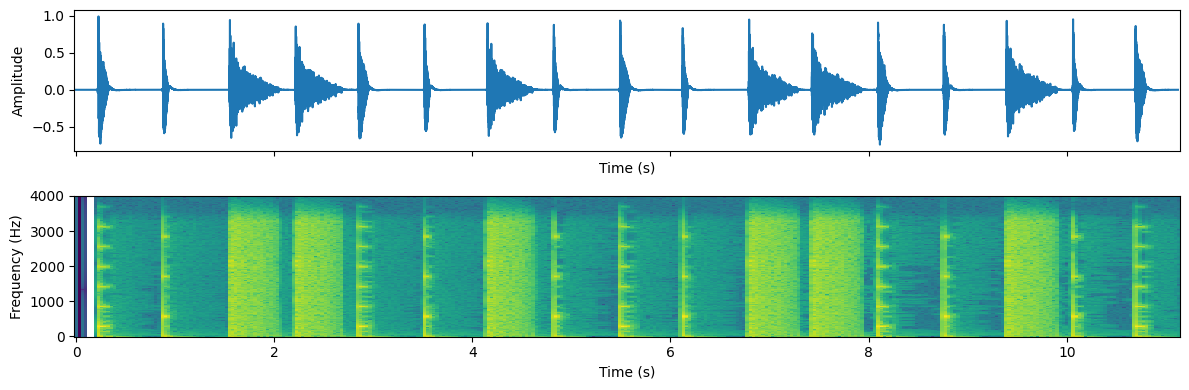

In [15]:
# stft parameters
frame_size = 516
lag = frame_size / 2 # 50% overlap
window = 'hanning'
# Plotting ... 
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
t = np.arange(len(synth))/Fs
axes[0].plot(t, synth)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
overlap_size = frame_size - lag
f, t, S = scipy.signal.stft(synth, fs=Fs, nperseg=frame_size, noverlap=overlap_size)
S_dB = 20*np.log10(abs(S))
axes[1].pcolormesh(t, f, S_dB, shading='auto')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
fig.tight_layout()
plt.show()



There are 3 distinct sounds in the signal from the sound file. In essense, a 'boop', 'beep' and a highhat-like sound. This is also evident from the amplitudal plot, which follows the order above for the first three excitations on the plot. Upon further investigation the spectrogram plot illustrates that the sounds contain 7 frequencies for the 'boop', 3 for the 'beep', while the highhat is dispersed thoughout.

# 2.7

In no particular order: 

- (h) is the noise after it has passed through some unknown filtering, which is given by the modelling the surrounding environment, and reaches the primary microphone.

- (d) is the reference noise signal at the source. It acts as input to the adaptive filtering algorithm (LMS). 

- (a) is the approximation of noise at the microphone. It is derived by learning a weighted form of (d).

- (b) Error signal, ie. approximation of the source after the noise has been subtracted from the primary signal. This guides the adaptive process. 

- (w) Filtering coefficients, or weights ($\theta$) learned by the adaptive algorithm to cancel out the noise.

- (c) Update of the weights based on error and input-term combinations.

The adaptive algorithms rely on the error term being uncorrelated with the source signal's input noise, otherwise the filter would reduce components of the signal instead.

In [11]:
from scipy.io import loadmat
from convmtx import convmtx
from lms import lms
from nlms import nlms
from rls import rls
Fs = 8000 # Specified sampling freq
# Signal (Speech)
s = loadmat(f'data/problem2_7_speech.mat')['speech'].flatten()
N = len(s)
noiselevel = 1.0 # N(0,1) noise
n = np.random.randn(N) * noiselevel # 2.1.5
filters = [loadmat(f'data/problem2_7_'+_filter+'.mat')[_filter].flatten() for _filter in ['lpir', 'hpir', 'bpir']]

# Filtering out noise (ie. (h)) using bpir filter
h = signal.lfilter(filters[2], 1, n).flatten()
# Adding filtered noise to signal
pm = s + h

In [12]:
L = len(filters[0]) # dimension of the unknown vector
N = len(pm)         # number of data samples
# LMS params
mu_lms = 0.09       # step-size
# NLMS params
mu_nlms = 0.1       # step-size ( 0 < mu < 2)
delta = 1e-3        # regularization (small)
# RLS params
beta = 0.995        # forget factor
lambda_ = 1e-3      # regularization
# Execute
_, e_lms = lms(n, pm, L, mu_lms)
_, e_nlms = nlms(n, pm, L, mu_nlms, delta)
_, e_rls = rls(n, pm, L, beta, lambda_)

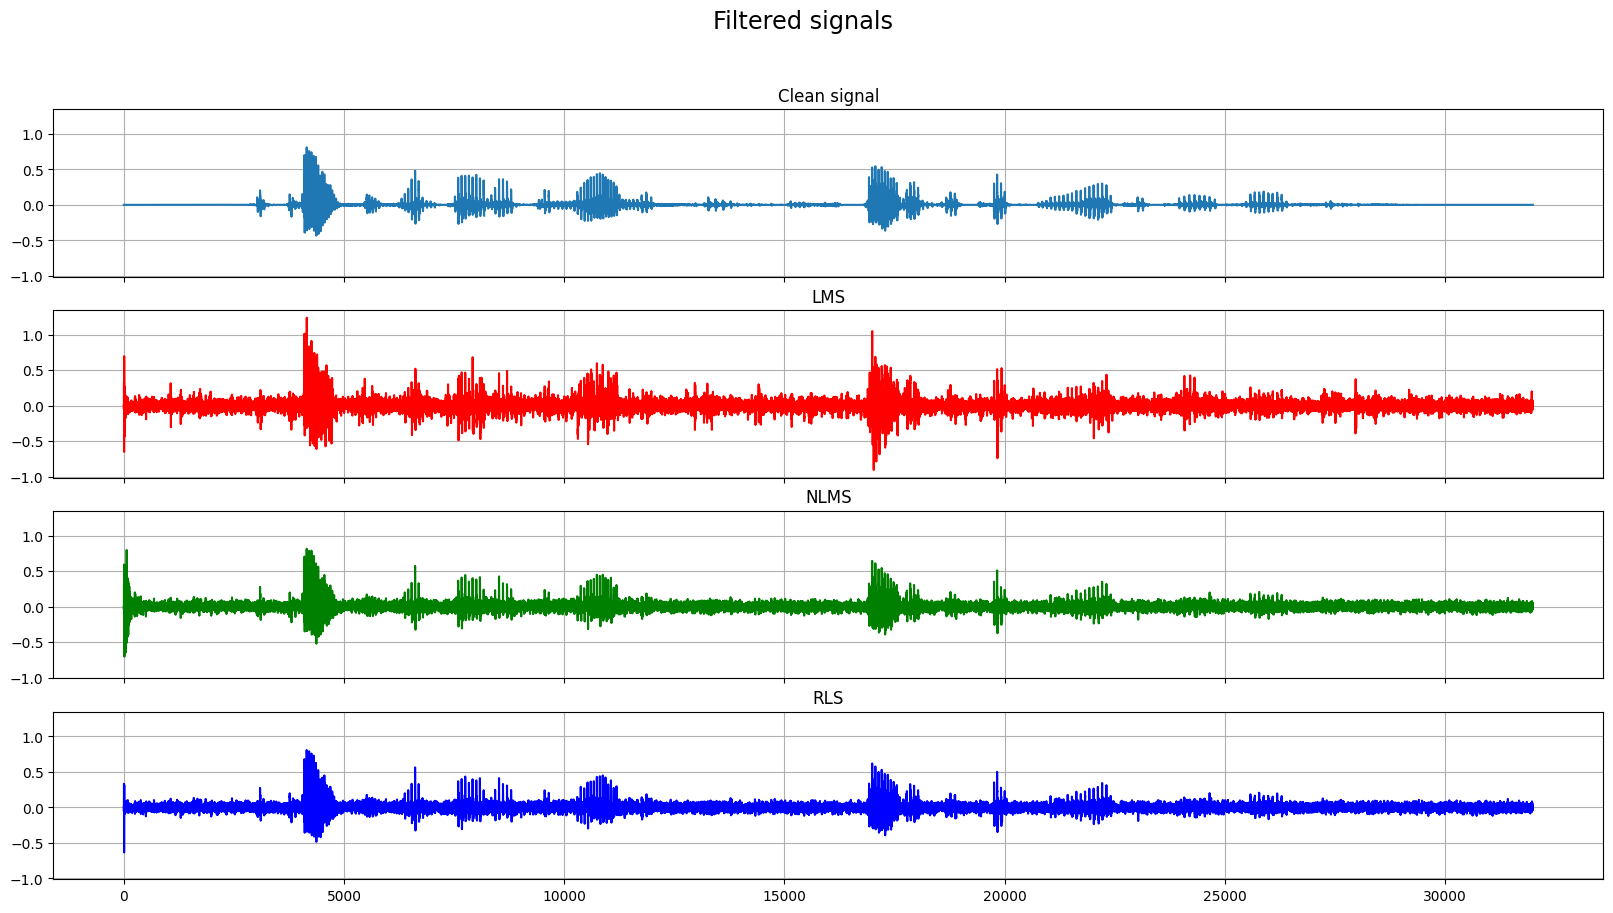

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
colors = [None, 'r', 'g', 'b']
for i, method in enumerate([(s, 'Clean signal'), (e_lms, 'LMS'), (e_nlms, 'NLMS'), (e_rls, 'RLS')]):
    axes[i].plot(method[0], color = colors[i], label = method[1])
    axes[i].grid('on')
    axes[i].set_title(method[1])
plt.suptitle('Filtered signals', fontsize = 'xx-large') 
plt.show()

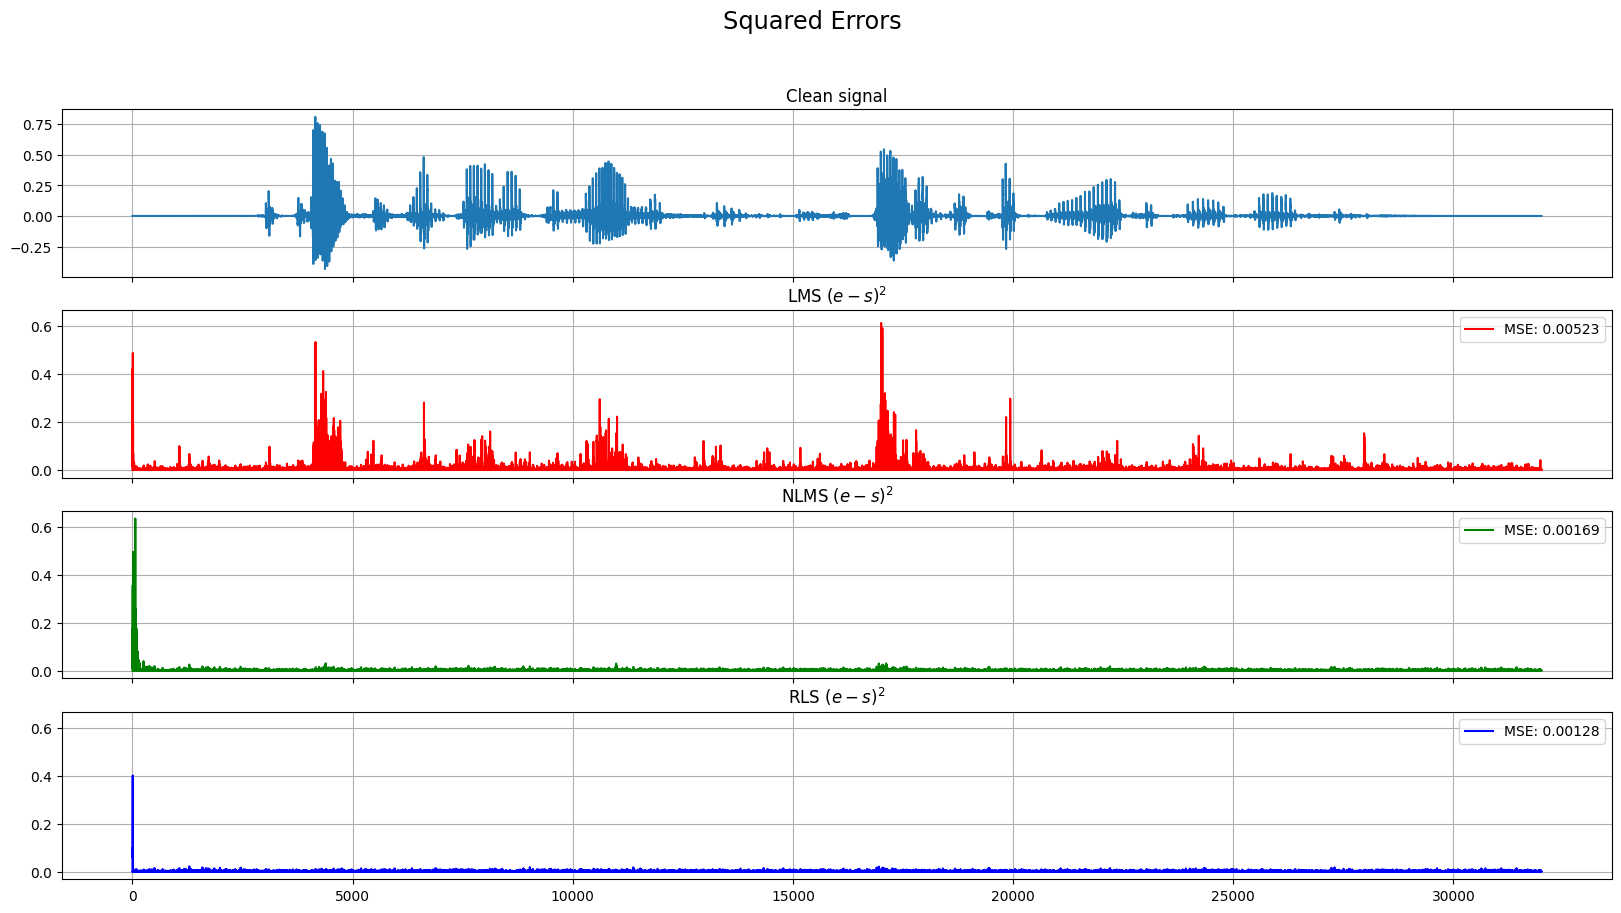

In [14]:
# Squared errors
SE_rls = (e_rls - s)**2
SE_lms = (e_lms - s)**2
SE_nlms = (e_nlms - s)**2
fig, axes = plt.subplots(4, 1, figsize=(20, 10), sharex=True)
for i, method in enumerate([(s, 'Clean signal'), (SE_lms, r'LMS $(e - s)^2$'), (SE_nlms, r'NLMS $(e - s)^2$'), (SE_rls, r'RLS $(e - s)^2$')]):
    axes[i].plot(method[0], color = colors[i], label = 'MSE: '+str(np.mean(method[0]))[:7])
    axes[i].grid('on')
    axes[i].set_title(method[1])
    if i != 0:
        axes[i].sharey(axes[1])
        axes[i].legend()
plt.suptitle('Squared Errors', fontsize = 'xx-large') 
plt.show()

Evidently, the MSE of the RLS is the lowest. NLMS is definitely better than LMS.